In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = MNIST(root='./MNIST_data', train=True, transform=transforms.ToTensor())

## 训练和验证数据集

In [3]:
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [6]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

In [7]:
print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [31740 58766 54820  8978 19592 10747   618  8422 34609 50591 35674 23664
 14369 27388 22583 51038 49110 48520 40052  4826]


### 数据加载器

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [15]:
batch_size=100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, 
                          batch_size, 
                          sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,
                        batch_size, 
                        sampler=val_sampler)

## 模型

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [11]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0008, -0.0261,  0.0116,  ..., -0.0120,  0.0081, -0.0309],
        [-0.0137,  0.0235, -0.0265,  ..., -0.0221, -0.0023, -0.0260],
        [ 0.0126, -0.0134,  0.0036,  ...,  0.0194, -0.0203,  0.0144],
        ...,
        [-0.0208, -0.0026, -0.0097,  ..., -0.0124, -0.0196, -0.0120],
        [ 0.0300,  0.0332, -0.0251,  ...,  0.0026,  0.0045,  0.0190],
        [-0.0081,  0.0281, -0.0054,  ..., -0.0269,  0.0290,  0.0353]],
       requires_grad=True)

In [12]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0201,  0.0248,  0.0226,  0.0112, -0.0298, -0.0088, -0.0226, -0.0166,
        -0.0103, -0.0119], requires_grad=True)

In [19]:
train_loader

In [20]:
images.shape

torch.Size([100, 1, 28, 28])

In [17]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

torch.Size([100, 1, 28, 28])


RuntimeError: size mismatch, m1: [2800 x 28], m2: [784 x 10] at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

### 重新定义Model

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [23]:
print(model.linear.weight.shape, model.linear.bias.shape)
# list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


In [24]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[ 0.1127,  0.3245,  0.1016, -0.2402, -0.3698, -0.0852, -0.1537, -0.2558,
         -0.1362,  0.1797],
        [-0.0473,  0.3869, -0.0494, -0.2872, -0.6252, -0.4809, -0.2961, -0.5301,
          0.0825,  0.1199]])


## 损失函数

In [26]:
import torch.nn.functional as F

In [27]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1153, 0.1425, 0.1140, 0.0810, 0.0712, 0.0946, 0.0883, 0.0798, 0.0899,
         0.1233],
        [0.1081, 0.1668, 0.1078, 0.0850, 0.0606, 0.0700, 0.0842, 0.0667, 0.1230,
         0.1277]])
Sum:  1.0


In [28]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

tensor([1, 1, 1, 9, 9, 9, 2, 6, 9, 9, 2, 8, 1, 9, 1, 8, 1, 1, 1, 9, 1, 1, 2, 1,
        0, 9, 2, 9, 1, 9, 1, 1, 1, 9, 8, 0, 9, 0, 9, 0, 9, 0, 1, 9, 9, 1, 9, 9,
        2, 1, 8, 2, 9, 1, 9, 9, 2, 8, 1, 0, 9, 1, 9, 0, 9, 0, 0, 1, 8, 9, 9, 1,
        1, 0, 9, 1, 0, 1, 8, 0, 9, 1, 9, 1, 9, 8, 1, 9, 9, 0, 1, 1, 9, 9, 9, 1,
        9, 1, 9, 9])


In [29]:
labels

tensor([9, 8, 8, 0, 4, 4, 6, 7, 3, 9, 5, 1, 6, 0, 3, 2, 8, 6, 6, 5, 0, 8, 2, 2,
        8, 2, 6, 8, 8, 9, 2, 2, 8, 8, 6, 8, 4, 5, 2, 0, 7, 0, 8, 6, 2, 5, 7, 2,
        6, 1, 8, 6, 4, 4, 9, 7, 6, 8, 6, 7, 8, 6, 4, 8, 8, 5, 0, 1, 6, 0, 2, 9,
        9, 3, 9, 5, 7, 2, 5, 6, 9, 5, 5, 1, 4, 2, 1, 4, 9, 3, 9, 4, 3, 5, 4, 9,
        3, 2, 0, 2])

## 评测和损失函数

In [30]:
def accuracy(l1, l2):
    return torch.sum(l1 == l2).item() / len(l1)
accuracy(preds, labels)

0.16

In [32]:
loss_fn = F.cross_entropy

In [33]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2778, grad_fn=<NllLossBackward>)


## 优化器

In [34]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 训练模型

In [35]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate loss
    preds = model(xb)
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [36]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [38]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3049, Accuracy: 0.2003


In [39]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [40]:
# Redifine model and optimizer
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.8730, accuracy: 0.6674
Epoch [2/5], Loss: 1.5762, accuracy: 0.7462
Epoch [3/5], Loss: 1.3673, accuracy: 0.7762
Epoch [4/5], Loss: 1.2170, accuracy: 0.7949
Epoch [5/5], Loss: 1.1054, accuracy: 0.8037


In [43]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.0201, accuracy: 0.8130
Epoch [2/5], Loss: 0.9530, accuracy: 0.8205
Epoch [3/5], Loss: 0.8987, accuracy: 0.8254
Epoch [4/5], Loss: 0.8541, accuracy: 0.8292
Epoch [5/5], Loss: 0.8166, accuracy: 0.8335


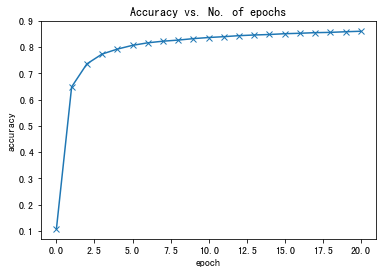

In [44]:
# Replace these values with your results
accuracies = [0.1076, 0.6486, 0.7362, 0.7737, 0.7925, 0.8069, 
              0.8165, 0.8227, 0.8269, 0.8325, 0.8367,
              0.8399, 0.8438, 0.8463, 0.8482, 0.8512,
              0.8529, 0.8552, 0.8563, 0.8587, 0.8606]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## 测试验证集

In [46]:
# Define test dataset
test_dataset = MNIST(root='./MNIST_data/',
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


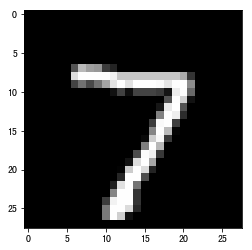

In [47]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [48]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


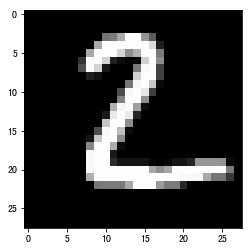

In [57]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 1


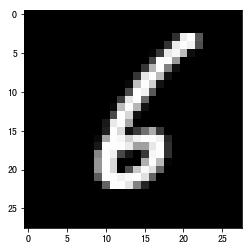

In [53]:
img, label = test_dataset[1886]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [58]:
test_loader = DataLoader(test_dataset, batch_size=200)

test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.7913, Accuracy: 0.8432


## 保存和加载模型

In [66]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [67]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0112, -0.0111, -0.0061,  ...,  0.0260,  0.0208, -0.0295],
                      [ 0.0132,  0.0133, -0.0140,  ..., -0.0125,  0.0279,  0.0010],
                      [-0.0027,  0.0239,  0.0299,  ...,  0.0184, -0.0233,  0.0195],
                      ...,
                      [ 0.0199,  0.0115, -0.0183,  ..., -0.0297, -0.0230,  0.0113],
                      [ 0.0089,  0.0119, -0.0065,  ...,  0.0185, -0.0026, -0.0302],
                      [ 0.0005, -0.0333,  0.0241,  ...,  0.0319, -0.0329, -0.0007]])),
             ('linear.bias',
              tensor([-0.0694,  0.0464, -0.0149, -0.0065,  0.0278,  0.0353, -0.0022,  0.0189,
                      -0.0580,  0.0276]))])

In [68]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0112, -0.0111, -0.0061,  ...,  0.0260,  0.0208, -0.0295],
                      [ 0.0132,  0.0133, -0.0140,  ..., -0.0125,  0.0279,  0.0010],
                      [-0.0027,  0.0239,  0.0299,  ...,  0.0184, -0.0233,  0.0195],
                      ...,
                      [ 0.0199,  0.0115, -0.0183,  ..., -0.0297, -0.0230,  0.0113],
                      [ 0.0089,  0.0119, -0.0065,  ...,  0.0185, -0.0026, -0.0302],
                      [ 0.0005, -0.0333,  0.0241,  ...,  0.0319, -0.0329, -0.0007]])),
             ('linear.bias',
              tensor([-0.0694,  0.0464, -0.0149, -0.0065,  0.0278,  0.0353, -0.0022,  0.0189,
                      -0.0580,  0.0276]))])

### 验证加载是否正确

In [69]:
test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.7913, Accuracy: 0.8432
